# Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

% matplotlib inline

print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Pandas version 0.20.3
Numpy version 1.14.0


# Read in Cleaned Data

In [3]:
data = pd.read_pickle('../data/cleaned_data.pkl')

In [5]:
target_features = data.loc[:,['Graduation_Rate_School', 'Average_ACT_School', 'crimes_per_student', 
                              'dollars_per_student', 'percent_diff_budget', 'percent_low_income']]

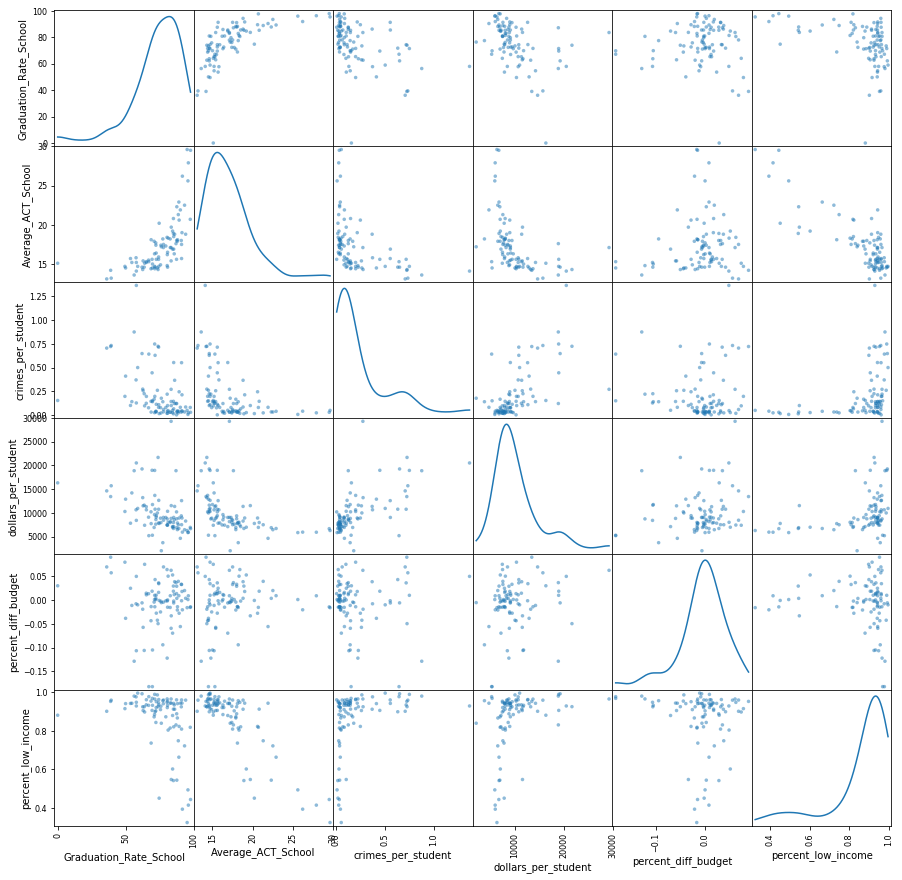

In [18]:
scatter_matrix(target_features, alpha=0.5, s=50, figsize=(15, 15), diagonal='kde');

In [20]:
target_features.describe()

,Graduation_Rate_School,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,75.154444,17.351111,0.207606,9983.658913,-0.005093,0.863946
std,15.811567,3.383942,0.252492,4338.613803,0.051105,0.153748
min,0.000000,13.100000,0.003534,2009.700787,-0.181877,0.322761
25%,68.725000,15.025000,0.040456,7428.855187,-0.018475,0.849199
50%,76.850000,16.450000,0.112072,8842.216976,-0.000314,0.925307
75%,86.025000,18.275000,0.240679,11330.578561,0.023518,0.950649
max,97.800000,29.600000,1.362832,29269.030172,0.089964,0.996094


# MVP Linear Model

## Univariate Model

### Split data into train and test 

In [73]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


In [74]:
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)

In [116]:
X = np.array(target_features.loc[:, 'Average_ACT_School']).reshape(-1,1)
#X = np.array(target_features.loc[:, ['Average_ACT_School', 'dollars_per_student']])
y = np.array(target_features.loc[:,'Graduation_Rate_School'])

alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]

In [117]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return mse
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [118]:
def lasso_test(data, target, alphas):
    
    for alpha in alphas:
        train_errors = []
        validation_errors = []

        for train_index, val_index in kf.split(data, target):

            # split data
            X_train, X_val = data[train_index], data[val_index]
            y_train, y_val = target[train_index], target[val_index]

            # instantiate model
            lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)

            #calculate errors
            train_error, val_error = calc_metrics(X_train, y_train, X_val, y_val, lasso)

            # append to appropriate list
            train_errors.append(train_error)
            validation_errors.append(val_error)

        # generate report
        print('alpha: {:6} | mean(train_error): {:7} | mean(val_error): {}'.
              format(alpha,
                     round(np.mean(train_errors),4),
                     round(np.mean(validation_errors),4)))

In [119]:
lasso_test(X, y, alphas)

alpha: 0.0001 | mean(train_error): 147.4067 | mean(val_error): 153.9822
alpha:  0.001 | mean(train_error): 147.4067 | mean(val_error): 153.9819
alpha:   0.01 | mean(train_error): 147.4067 | mean(val_error): 153.9787
alpha:    0.1 | mean(train_error): 147.4076 | mean(val_error): 153.9481
alpha:      1 | mean(train_error): 147.4957 | mean(val_error): 153.7333
alpha:   10.0 | mean(train_error): 156.3062 | mean(val_error): 160.7837


## Plot Univariate Model

In [120]:
class LinearRegression:
    
    def __init__(self):
        pass
        
    def fit(self, X, y):
        X = np.array(X)
        self.data = np.c_[np.ones(X.shape[0]), X]
        self.target = np.array(y)
        
        xtx = np.dot(self.data.T, self.data) ## x-transpose times x
        inv_xtx = np.linalg.inv(xtx) ## inverse of x-transpose times x
        xty = np.dot(self.data.T, self.target) ## x-transpose times y
        self.thetas = np.dot(inv_xtx, xty)
        self.intercept_ = self.thetas[0]
        self.coef_ = self.thetas[1:]
        
        return self.thetas
    
    def predict(self, testX):
        X = np.array(testX)
        self.testdata = np.c_[np.ones(X.shape[0]), X]
        self.y_prediction = self.testdata.dot(self.thetas)
        return self.y_prediction

In [121]:
def predict(self, testX):
    X = np.array(testX)
    self.testdata = np.c_[np.ones(X.shape[0]), X]
    self.y_prediction = self.testdata.dot(self.thetas)
    return self.y_prediction

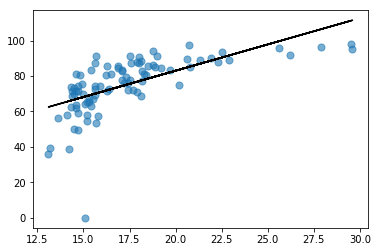

In [122]:
lr = LinearRegression()

lr.fit(X, y)


plt.scatter(X, y, alpha=0.6, s=50)
plt.plot(X, lr.predict(X), c='k')